In [70]:
import yaml
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, List, Tuple, Callable, TypeVar, Union
import matplotlib.pyplot as plt

In [12]:
def sgp(x):
  return 1 if x >= 0 else -1

"""
  Double-digit precision float implementation
"""
class Num:
  def __init__(self, i, f):
    self.sgn = sgp(i) * sgp(f) 
    self.i = int(np.abs(i))
    self.f = int(np.abs(f))

  def __add__(self, other):
    f_raw = self.f + other.f
    di = f_raw // 100
    f = f_raw % 100

    return Num(self.i + other.i + di, f)

  def __neg__(self):
    return Num(-self.i, self.f)

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    # (a + be-2)(c + de-2) = ac + (ad)e-2 + (bc)e-2 + (bd)e-4
    #                      = ac + (ad + bc + bde-2)e-2

    if isinstance(other, Num):
      f_raw = self.i * other.f + self.f * other.i + (self.f * other.f * 1e-2)
      df = f_raw % 100
      di = f_raw // 100

      return Num(
        self.sgn * other.sgn * (self.i * other.i + di), 
        df
      )
    elif isinstance(other, (float, int)):
      return self * Num.ofFloat(other)
    else:
      raise Exception(f"Unhandled scalar type in Num.__mul__: {type(other)} ({other})")

  def __repr__(self):
    s = '-' if self.sgn == -1 else '(0)' if self.sgn == 0 else ''

    return f'{s}{self.i}.{self.f:02}'

  def ofFloat(f):
    return Num(i := np.floor(f), np.floor(f * 100) - i*100)

  def toFloat(self):
    return self.sgn * (self.i + self.f/100)

  def zero():
    return Num(0, 0)

In [40]:
RawEntry = Union[
    Tuple[str, Union[float, int], str], 
    Tuple[str, Union[float, int], str, str]
  ]

class Entry:
  name: str
  amount: Num
  category: str
  desc: str

  def __init__(
    self, 
    arr: RawEntry):
    match arr:
      case [ name, amount, category ]:
        self.name = name
        self.amount = Num.ofFloat(amount)
        self.category = category
        self.desc = ''

      case [ name, amount, category, desc ]:
        self.name = name
        self.amount = Num.ofFloat(amount)
        self.category = category
        self.desc = desc

  def __repr__(self):
    space = ", " if self.desc else ''
    
    return f'[{self.name}, {self.amount}, {self.category}{space}{self.desc}]'

In [71]:
T = TypeVar("T")
U = TypeVar("U")

def aggregateByTag(
    processor: Callable[[U, T], U], 
    tagExtractor: Callable[[T], str], 
    elements: List[T], 
    initial: U
  ) -> List[Tuple[str, U]]:
    tags = dict()

    for element in elements:
      tag = tagExtractor(element)

      if tag not in tags:
        tags[tag] = initial

      tags[tag] = processor(tags[tag], element)

    return list(tags.items())

def unzip(elements: List[Tuple[T, U]]) -> Tuple[List[T], List[U]]:
  lefts, rights = [], []
  for (left, right) in elements:
    lefts.append(left)
    rights.append(right)

  return (lefts, rights)

In [228]:
class Report:
  budget: Optional[Num]
  title: str
  categoryCosts: List[Tuple[str, Num]]
  totalCosts: Num
  categoryIncomes: List[Tuple[str, Num]]
  totalIncomes: Num
  balance: Optional[Num]

  def __init__(
    self, 
    title = "", 
    budget: Optional[Num] = None, 
    expenses: List[Entry] = [], 
    incomes: List[Entry] = []
  ):
    self.title = title
    self.budget = budget

    self.categoryCosts = aggregateByTag(
      processor = lambda total, entry: total + entry.amount,
      tagExtractor = lambda entry: entry.category,
      elements = expenses,
      initial = Num.zero()
    )

    self.categoryIncomes = aggregateByTag(
      processor = lambda total, entry: total + entry.amount,
      tagExtractor = lambda entry: entry.category,
      elements = incomes,
      initial = Num.zero()
    )
    self.totalCosts = (aggregateByTag(
      processor = lambda total, cost: total + cost[1],
      tagExtractor = lambda _: '',
      elements = self.categoryCosts,
      initial = Num.zero()
    ) or [("default", Num.zero())])[0][1]

    self.totalIncomes = (aggregateByTag(
      processor = lambda total, income: total + income[1],
      tagExtractor = lambda _: '',
      elements = self.categoryIncomes,
      initial = Num.zero()
    ) or [("default", Num.zero())])[0][1]

    self.balance = self.totalIncomes - self.totalCosts
    print((self.categoryCosts, self.totalCosts))

  def __splitEntriesByTypes(entries: List[RawEntry] = []) -> Tuple[List[Entry], List[Entry]]:
    EXPENSE_KEY = "expense"
    INCOME_KEY = "income"

    entryTypes = dict(
      aggregateByTag(
        processor = lambda types, rawEntry: types + [Entry(rawEntry)],
        tagExtractor = lambda rawEntry: INCOME_KEY if rawEntry[2].startswith(INCOME_KEY) else EXPENSE_KEY,
        elements = entries,
        initial = []
      )
    )

    expenses = entryTypes[EXPENSE_KEY] if EXPENSE_KEY in entryTypes else []
    incomes = entryTypes[INCOME_KEY] if INCOME_KEY in entryTypes else []

    # strip the `INCOME_KEY` prefix from income categories
    for income in incomes:
      income.category = income.category.strip(INCOME_KEY).strip()

    return expenses, incomes

  def ofDay(year: int = 2022, month: int = 1, day: int = 1, entries: List[RawEntry] = []) -> Report:
    expenses, incomes = Report.__splitEntriesByTypes(entries)

    return Report(
      title = f'Daily report: {year}.{month:02}.{day:02}',
      expenses = expenses,
      incomes = incomes
    )

  def ofMonth(year: int = 2022, month: int = 1, monthEntry: dict = dict()) -> Report:
    BUDGET_KEY = 'budget'
    budget = None
    entries = []

    # check for budget
    if BUDGET_KEY in monthEntry:
      budget = monthEntry[BUDGET_KEY]

    # aggregate the daily entries
    for dailyEntries in [
      entries 
      for (key, entries) 
      in monthEntry.items() 
      if isinstance(entries, list)
      ]:
      entries.extend(dailyEntries)
    
    # split the entries
    expenses, incomes = Report.__splitEntriesByTypes(entries)

    return Report(
      title = f'Monthly report: {year}.{month:02}',
      budget = budget,
      expenses = expenses,
      incomes = incomes
    )

  def ofYear(year: int = 2022, yearEntry: dict = dict()) -> Report:
    entries = []

    # aggregate the entries
    for monthEntry in [
      entry
      for (key, entry)
      in yearEntry.items()
      if isinstance(entry, dict)
      ]:
      for dailyEntries in [
        entries 
        for (key, entries) 
        in monthEntry.items() 
        if isinstance(entries, list)
        ]:
        entries.extend(dailyEntries)

    # split the entries
    expenses, incomes = Report.__splitEntriesByTypes(entries)

    return Report(
      title = f'Yearly report: {year}',
      expenses = expenses,
      incomes = incomes
    )


  def __pie(self, ax: plt.Axes, elements: List[Tuple[str, Num]], title: str, side: int):
    labels, values = unzip(elements)
    
    values = [value.toFloat() for value in values]
    totalValues = sum(values)

    patches, text, *_ = ax.pie(
      values,
      autopct = lambda percent: f"{percent:.1f}%"
    )

    ax.legend(
      patches, 
      labels=[f'{label} ({value}zł)' for (label, value) in elements], 
      loc='center', 
      bbox_to_anchor=(0.5, 0.0),
      fontsize=5
    )


    ax.set(title=title)

  def display(self):
    plt.tight_layout()
    fig = plt.figure(
      constrained_layout=True, 
      dpi=300
    )
    axes = fig.subplots(1, 2)

    fig.patch.set_facecolor('w')
    plt.suptitle(self.title)

    self.__pie(axes[0], self.categoryCosts, f'Expenses: {self.totalCosts} zł', -1)
    self.__pie(axes[1], self.categoryIncomes, f'Income: {self.totalIncomes} zł', 1)

    plt.show()
  

([('accommodation', 632.70), ('hygiene', 172.17), ('food', 89.32), ('clothes', 315.79)], 1209.98)


/tmp/ipykernel_6694/2498725251.py:148: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(


<Figure size 432x288 with 0 Axes>

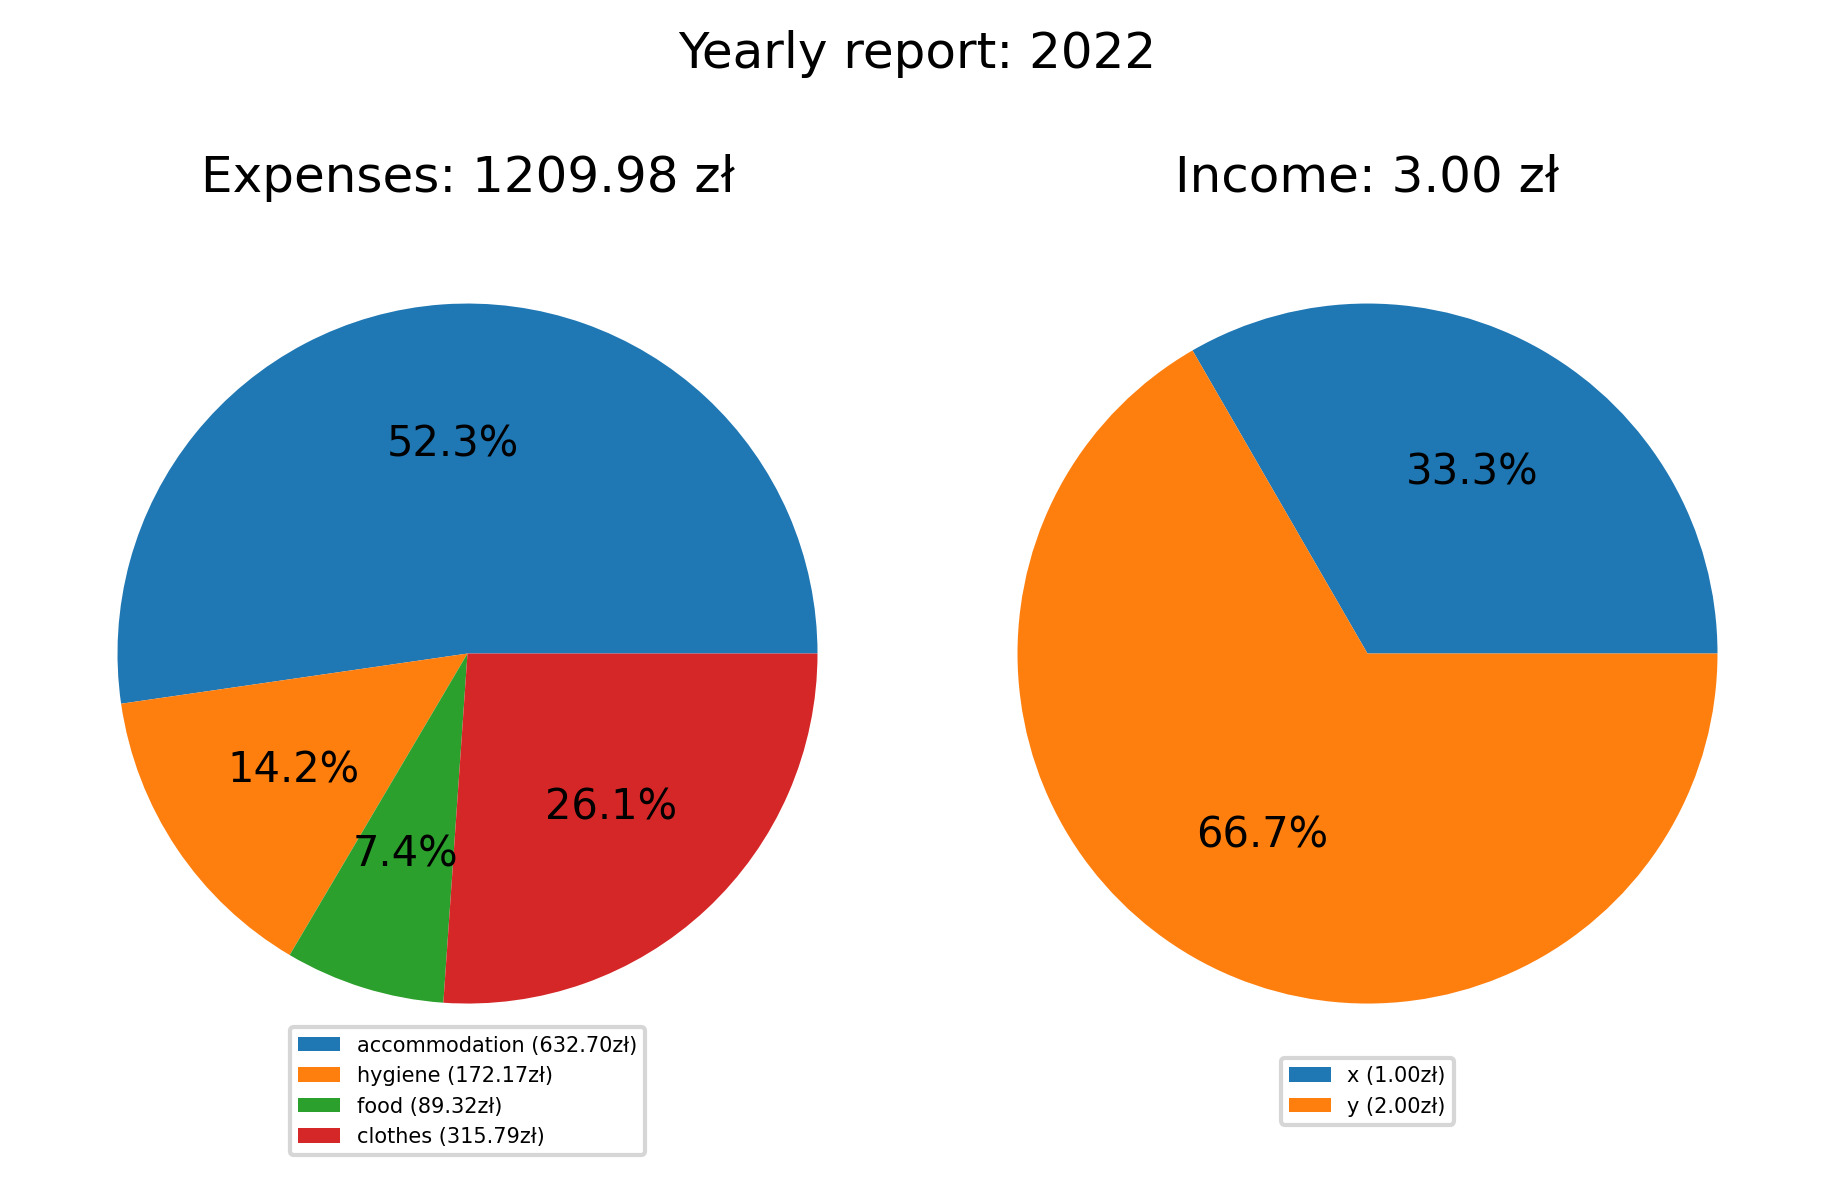

In [229]:
with open("./db.yaml") as f:
  db = yaml.load(f, Loader=yaml.FullLoader)
  year = dict(db)[2022]
  month = dict(db)[2022][10]
  day = dict(db)[2022][9][29]

  # Report.ofDay(year=2022, month=9, day=29, entries=day).display()
  # Report.ofMonth(year=2022, month=10, monthEntry=month).display()
  Report.ofYear(year=2022, yearEntry=year).display()
